In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import EVA

print("Todos los paquetes importados correctamente")


Todos los paquetes importados correctamente


In [86]:
station = 1330
# We create some random continuous time series with some extremes
flowdata = pd.read_csv(f"../../../Status_Outlook_Bulletin/stations/data/{station}.csv",parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Convertir el índice a datetime por si acaso
flowdata.index = pd.to_datetime(flowdata.index, dayfirst=True)
diff = pd.date_range(start = flowdata.index[0].strftime('%Y-%m-%d'), end = flowdata.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
flowdata = flowdata.reindex(diff,fill_value=None)
# Set index Fecha
flowdata.index.name = 'Fecha'
flowdata = flowdata.rename_axis("date")
# Change columns names
flowdata.columns = ['flow']

#month and year column
flowdata['month'] = flowdata.index.month
flowdata['year'] = flowdata.index.year
flowdata = flowdata.reset_index()

#check whether or not there is enough data? 
print(station)
print(f"There are {flowdata['year'].max() - flowdata['year'].min()} years of data in this file.")
print(f"There are {sum(flowdata['flow'].isnull())} missing data points, which is {np.round(sum(flowdata['flow'].isnull())/len(flowdata) * 100,2)}% of the total data")

1330
There are 45 years of data in this file.
There are 1427 missing data points, which is 8.6% of the total data


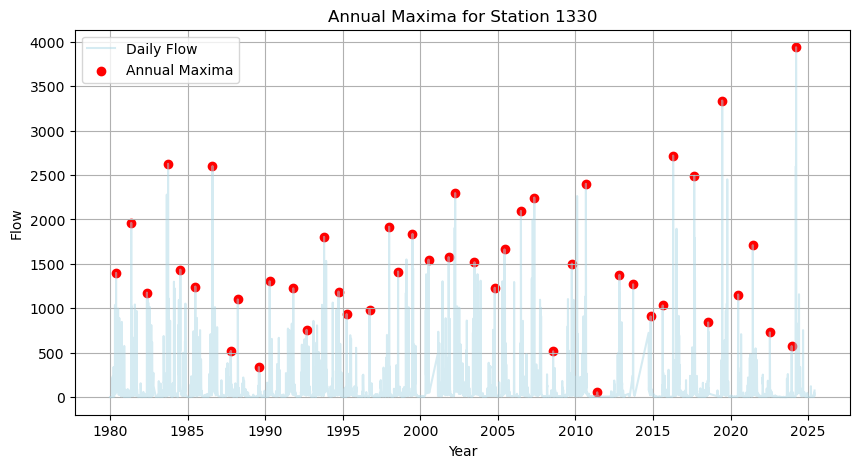

In [99]:
# Prepare the time series: set 'date' as index and use the 'flow' column
flowdata_ts = flowdata.set_index('date')['flow'].dropna()

# Agrupar los datos por año y encontrar la fecha del máximo
max_dates = flowdata_ts.groupby(flowdata_ts.index.year).idxmax()

# Usar las fechas encontradas para obtener los valores máximos
annual_maxima = flowdata_ts.loc[max_dates]

# Remover un año en especifico si no está completo
annual_maxima = annual_maxima[annual_maxima.index.year < 2025]

# Graficar annual maxima
plt.figure(figsize=(10, 5))
plt.plot(flowdata_ts.index, flowdata_ts.values, label='Daily Flow', color='lightblue', alpha=0.5)
plt.scatter(annual_maxima.index, annual_maxima.values, color='red', label='Annual Maxima')
plt.title(f'Annual Maxima for Station {station}')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.legend()
plt.grid()
plt.show()

In [100]:
model = EVA(flowdata_ts)

In [101]:
model.set_extremes(extremes=annual_maxima) 

In [102]:
model.fit_model()
summary = model.get_summary(
    return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000,5000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value     lower ci     upper ci
return period                                        
2.0             1405.501651  1206.313124  1642.356742
5.0             2131.627582  1832.251166  2461.833380
10.0            2612.965438  2217.881863  3036.423547
20.0            3074.812429  2581.315379  3592.557242
25.0            3221.330776  2695.450639  3767.892026
50.0            3672.708506  3054.523784  4309.494197
100.0           4120.774278  3392.097801  4866.153144
250.0           4710.740751  3857.720315  5582.550521
500.0           5156.216641  4191.746196  6115.672827
1000.0          5601.372426  4525.532058  6660.393517
5000.0          6634.505996  5299.686890  7924.295164


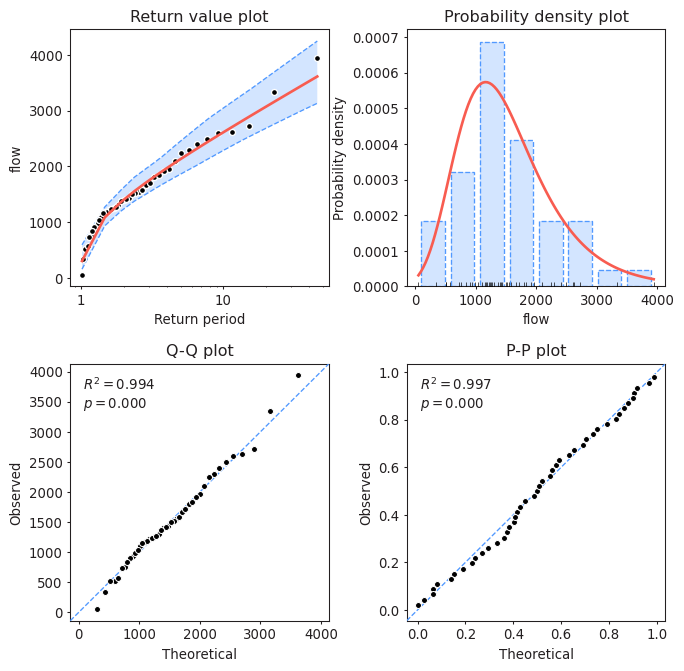

In [103]:
model.plot_diagnostic(alpha=0.95);
plt.show()

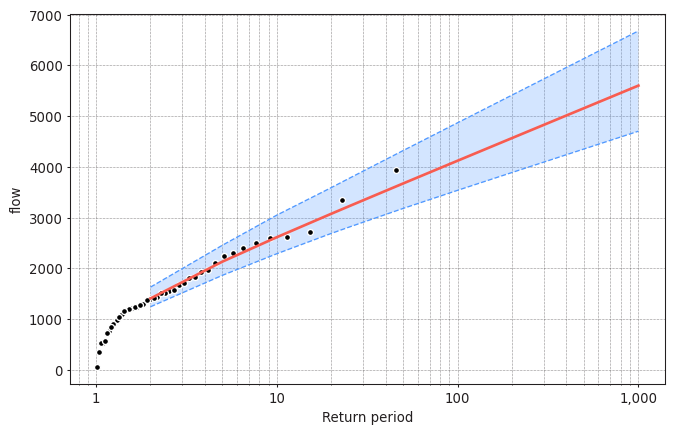

In [108]:
model.plot_return_values(alpha=0.95, return_period=[2, 5, 10, 20, 25, 50, 100, 250, 500, 1000]);
plt.show()